**Malaria Detection Using Convolutional Neural Networks**

This notebook presents a deep learning approach for detecting malaria-infected cells from microscopic blood smear images using a Convolutional Neural Network (CNN). The goal is to build and evaluate a binary image classification model that can distinguish between parasitized and uninfected cells.

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2
from sklearn.metrics import confusion_matrix,roc_curve
from os import name
import datetime
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dense, Input, InputLayer, Flatten, RandomFlip, RandomRotation, Resizing, Rescaling, Dropout
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalseNegatives, FalsePositives, Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras.callbacks import Callback,CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import L2
import wandb

# Dataset Exploration


In [ ]:
dataset, dataset_info=tfds.load("Malaria",as_supervised=True,shuffle_files=True,split=['train'],with_info=True)

This project uses the Malaria dataset provided by TensorFlow Datasets (TFDS), which contains 27,558 microscopic blood smear cell images. The dataset is balanced, consisting of two classes: Parasitized and Uninfected. Each image represents a segmented cell extracted from thin blood smear slides. The images are provided in RGB format and vary in spatial resolution, requiring resizing and normalization during preprocessing.

In [ ]:
print("Number of classes:", dataset_info.features['label'].num_classes)
print("Class 0:",dataset_info.features['label'].int2str(0))
print("Class 1: ",dataset_info.features['label'].int2str(1))

Number of classes: 2
Class 0: parasitized
Class 1:  uninfected


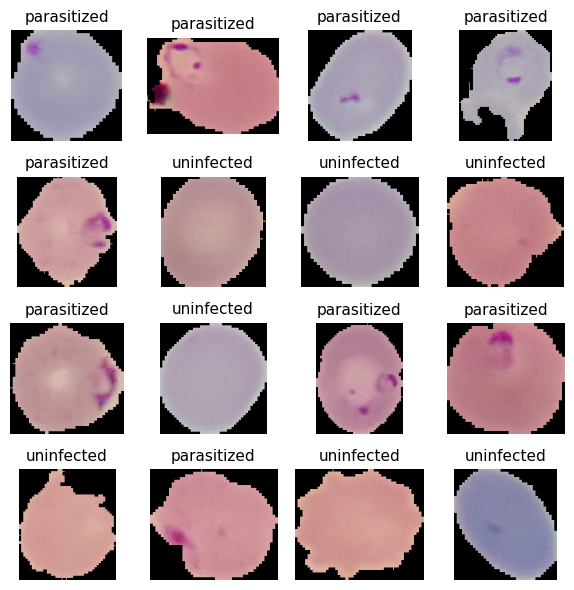

In [ ]:
plt.figure(figsize=(6, 6))

for i, (image, label) in enumerate(dataset[0].take(16)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)

    class_name = dataset_info.features['label'].int2str(label)
    plt.title(class_name, fontsize=11,)
    plt.axis('off')
plt.tight_layout()
plt.show()

Class Distribution:
Parasitized: 13,779 images (50.0%)
Uninfected: 13,779 images (50.0%)
Total: 27,558 images


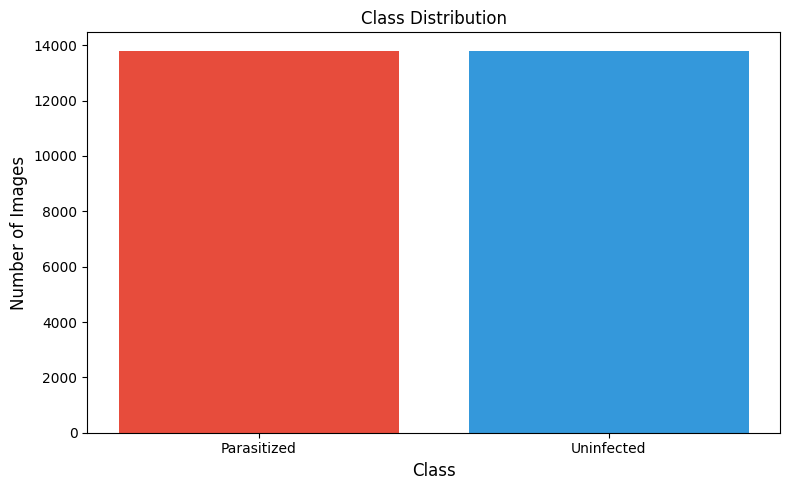

In [ ]:
class_counts = {'Parasitized': 0, 'Uninfected': 0}

for image, label in dataset[0]:
    if label.numpy() == 0:
        class_counts['Parasitized'] += 1
    else:
        class_counts['Uninfected'] += 1

total = sum(class_counts.values())

print("Class Distribution:")
print(f"Parasitized: {class_counts['Parasitized']:,} images ({class_counts['Parasitized']/total*100:.1f}%)")
print(f"Uninfected: {class_counts['Uninfected']:,} images ({class_counts['Uninfected']/total*100:.1f}%)")
print(f"Total: {total:,} images")


plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['#e74c3c', '#3498db'])
plt.title('Class Distribution')
plt.ylabel('Number of Images', fontsize=12)
plt.xlabel('Class', fontsize=12)


plt.tight_layout()
plt.show()

# Data Preprocessing

In [ ]:
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)

    train_data = dataset.take(train_size)
    remaining = dataset.skip(train_size)
    val_data = remaining.take(val_size)
    test_data = remaining.skip(val_size)

    return train_data, val_data, test_data

In [ ]:
train_data, val_data, test_data = split_dataset(dataset[0], train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)

print(f"Training samples: {len(train_data):,}")
print(f"Validation samples: {len(val_data):,}")
print(f"Test samples: {len(test_data):,}")

Training samples: 22,046
Validation samples: 2,755
Test samples: 2,757


In [ ]:
def resize_image(image, label):
    image = tf.image.resize(image, [224, 224])
    return image, label

def augment_image(image, label):
    image, label = resize_image(image, label)

    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    return image, label

Resizing is handled by the input pipeline and API, while normalization is embedded in the model to ensure consistent behavior during training and inference

In [ ]:
batch_size = 32

train_data = (train_data
              .shuffle(buffer_size=1000, reshuffle_each_iteration=True)
              .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
              .batch(batch_size)
              .prefetch(tf.data.AUTOTUNE))

val_data = (val_data
            .map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

test_data=(test_data.map(resize_image).batch(1))

# Model Training and Evaluation

In [ ]:
model=Sequential([
    InputLayer(shape=(224,224,3)),
    Rescaling(1./255),
    Conv2D(filters=6,kernel_size=3,strides=1,padding='valid',activation='relu'),
    MaxPool2D(pool_size=2,strides=2),
    Dropout(0.05),
    Conv2D(filters=16,kernel_size=3,strides=1,padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Flatten(),
    Dense(100,'relu'),
    BatchNormalization(),
    Dropout(0.05),
    Dense(10,'relu'),
    BatchNormalization(),
    Dense(1,'sigmoid')

])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,665,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,668,273 (17.81 MB)

 Trainable params: 4,668,021 (17.81 MB)

 Non-trainable params: 252 (1008.00 B)

In [ ]:
metrics=[TruePositives(name='tp'),TrueNegatives(name='tn'),FalsePositives(name='fp'),FalseNegatives(name='fn'),
         BinaryAccuracy(name='accuracy'),Precision(name='precision'),Recall(name='recall'),AUC(name='auc')]

In [ ]:
es_callback=EarlyStopping(patience=6,verbose=1)

In [ ]:
model_check_point=ModelCheckpoint(filepath="model.keras",monitor='val_loss',verbose=1,save_best_only=True)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.008),loss=BinaryCrossentropy(),metrics=metrics)

In [ ]:
lr_callback=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,verbose=1)

In [ ]:
wandb.login()

wandb: Currently logged in as: mina_nagy (Mina_team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project='Malaria_Detection',name='final_cnn_model')

In [ ]:
import numpy as np
import wandb
from wandb.integration.keras import WandbEvalCallback

class CustomEvalCallback(WandbEvalCallback):
    def __init__(
        self,
        val_data,
        num_samples=16,
        data_table_columns=["image"],
        pred_table_columns=["ground_truth", "predicted_class"]
    ):
        self.val_data = val_data
        self.num_samples = num_samples
        self._data_table_columns = data_table_columns
        self._pred_table_columns = pred_table_columns

        super().__init__(
            data_table_columns=self._data_table_columns,
            pred_table_columns=self._pred_table_columns
        )

    def add_ground_truth(self, ground_truth, step=None):
        pass

    def add_model_predictions(self, predictions, step=None):
        pass

    def on_train_end(self, logs=None):
        """
        Runs once after training finishes.
        At this point, model weights = BEST model
        (because EarlyStopping has restore_best_weights=True)
        """

        images = []
        ground_truth = []
        predictions = []

        collected = 0

        for x_batch, y_batch in self.val_data:
            x_np = x_batch.numpy()
            y_np = y_batch.numpy()

            if y_np.ndim > 1 and y_np.shape[-1] > 1:
                y_np = np.argmax(y_np, axis=-1)

            preds = self.model.predict(x_np, verbose=0)
            preds = (preds > 0.5).astype(int).flatten()

            for img, gt, pred in zip(x_np, y_np, preds):
                images.append(img)
                ground_truth.append(int(gt))
                predictions.append(int(pred))
                collected += 1

                if collected >= self.num_samples:
                    break

            if collected >= self.num_samples:
                break

        table = wandb.Table(columns=["image", "ground_truth", "predicted_class"])

        for img, gt, pred in zip(images, ground_truth, predictions):
            table.add_data(wandb.Image(img), gt, pred)

        wandb.log({"best_model_predictions": table})

        super().on_train_end(logs)


In [ ]:
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
custom_eval = CustomEvalCallback(
    val_data=val_data,
    data_table_columns=["image"],
    pred_table_columns=["ground_truth", "predicted_class"]
)

callbacks = [
    WandbMetricsLogger(),
    WandbModelCheckpoint("model.keras"),
    custom_eval,
    es_callback,
    model_check_point,
    lr_callback,
]


In [ ]:
history=model.fit(train_data,validation_data=val_data,epochs=20,verbose=1,callbacks=callbacks)

wandb:   1 of 1 files downloaded.  


Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6434 - auc: 0.6925 - fn: 1894.0697 - fp: 1809.6357 - loss: 0.6353 - precision: 0.6485 - recall: 0.6415 - tn: 3710.0144 - tp: 3626.2771
Epoch 1: val_loss improved from inf to 0.32197, saving model to model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.6435 - auc: 0.6927 - fn: 1895.8435 - fp: 1811.5188 - loss: 0.6351 - precision: 0.6486 - recall: 0.6416 - tn: 3716.1057 - tp: 3632.4797 - val_accuracy: 0.9053 - val_auc: 0.9561 - val_fn: 114.0000 - val_fp: 147.0000 - val_loss: 0.3220 - val_precision: 0.8971 - val_recall: 0.9183 - val_tn: 1213.0000 - val_tp: 1281.0000 - learning_rate: 0.0080
Epoch 2/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.9258 - auc: 0.9627 - fn: 320.6904 - fp: 499.1875 - loss: 0.2240 - precision: 0.9145 - recall: 0.9406 - tn: 5003.6597 - tp: 5200.4624
Epoch 2: val_loss improved from 0.32197 to 0.19881, saving model to model.keras
689/689 ━━━━━━━━━━━━━━━━━━━━ 59s 85ms/step 

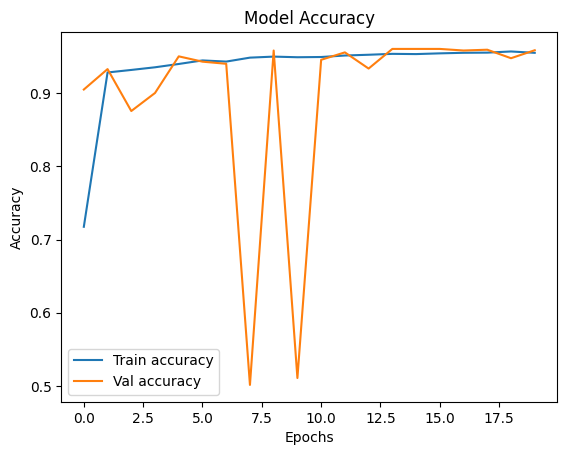

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train accuracy','Val accuracy'])
plt.show()

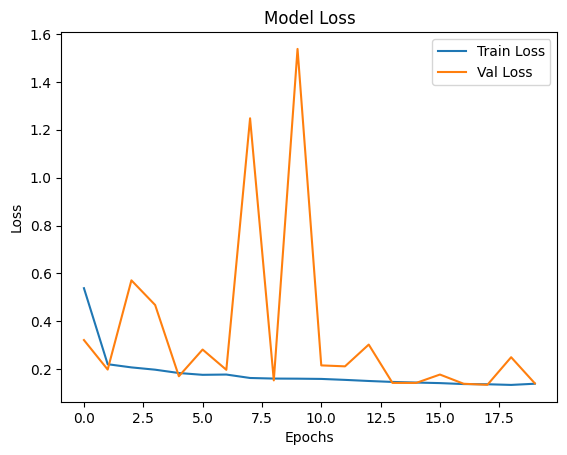

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train Loss','Val Loss'])
plt.show()

In [ ]:
model.evaluate(test_data)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9468 - auc: 0.9827 - fn: 27.9249 - fp: 43.7252 - loss: 0.1563 - precision: 0.9368 - recall: 0.9591 - tn: 646.1624 - tp: 661.6871


[0.15443533658981323,
 1308.0,
 1305.0,
 90.0,
 54.0,
 0.9477693438529968,
 0.9356223344802856,
 0.9603524208068848,
 0.9842087626457214]

In [ ]:
labels=[]
inp=[]
for x,y in test_data.as_numpy_iterator():
  labels.append(y)
  inp.append(x)
labels=np.array([i[0] for i in labels])

inp = np.array(inp)

predicted=model.predict(inp[:,0,...])


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


[[1301   89]
 [  54 1313]]


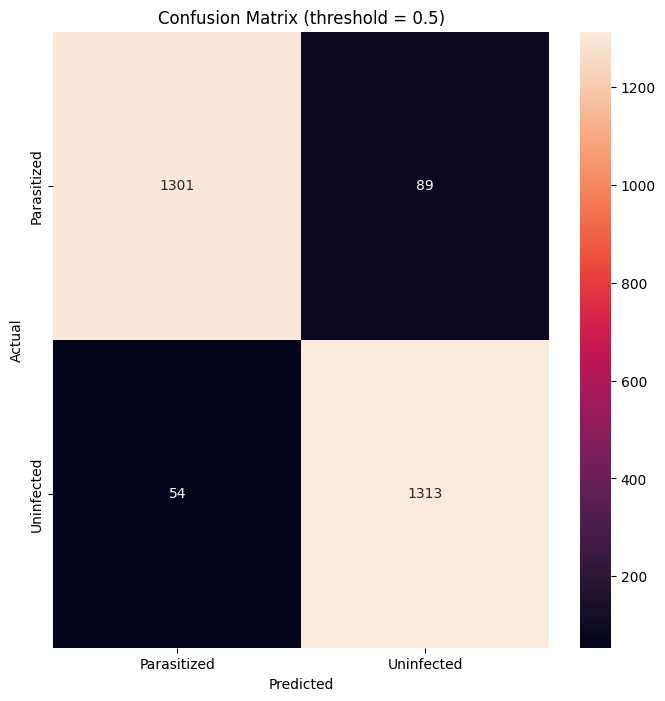

In [ ]:
threshold = 0.5

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

class_names = ["Parasitized","Uninfected"]


plt.figure(figsize=(8, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="rocket",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


In [ ]:
fp,tp,thresholds=roc_curve(labels,predicted)

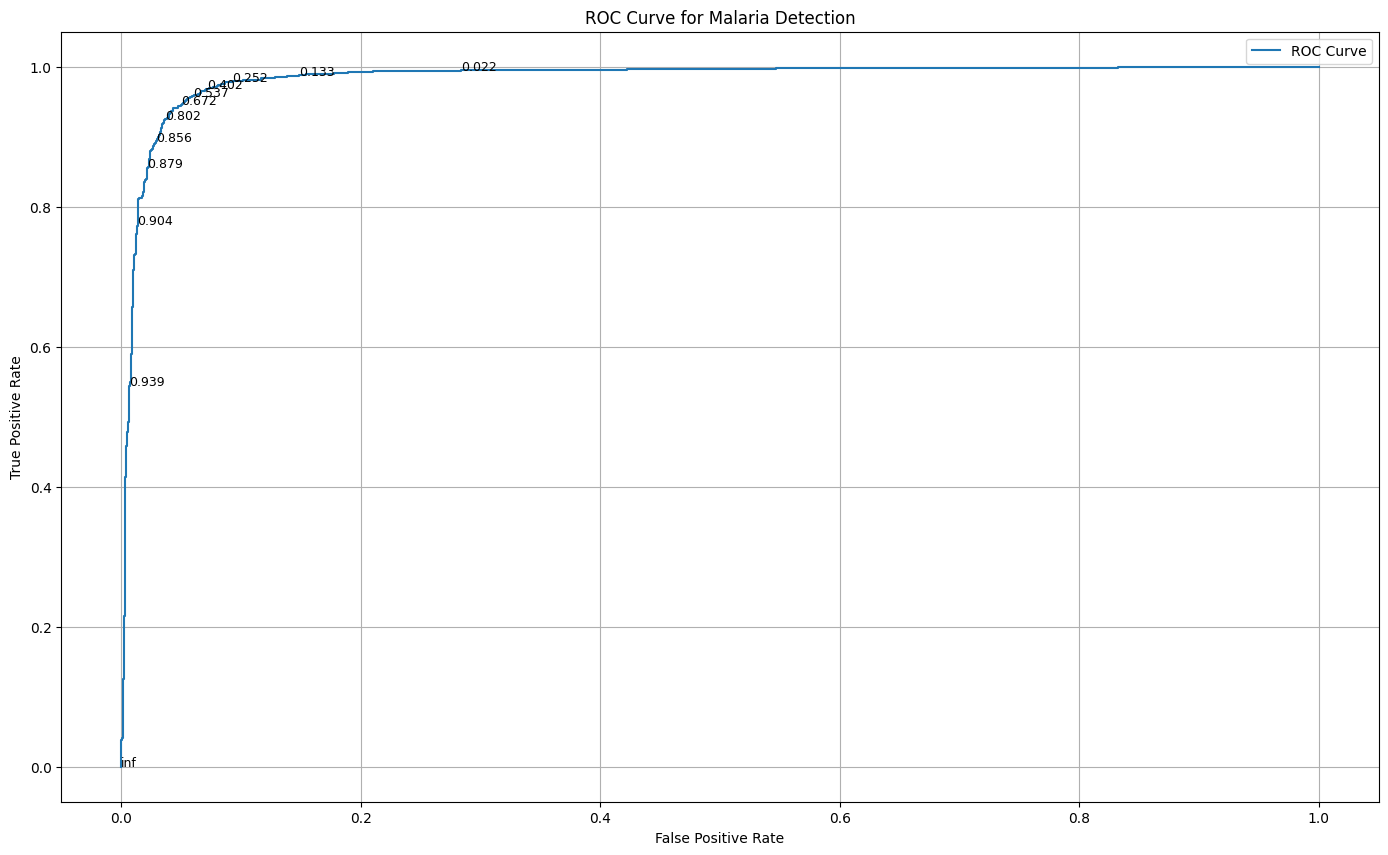

In [ ]:
fig, ax = plt.subplots(figsize=(17, 10))

ax.plot(fp, tp, label="ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve for Malaria Detection")
ax.grid(True)

skip = 20
for i in range(0, len(thresholds), skip):
    ax.text(fp[i], tp[i], f"{thresholds[i]:.3f}", fontsize=9)

ax.legend()
plt.show()

[[1320   70]
 [  74 1293]]


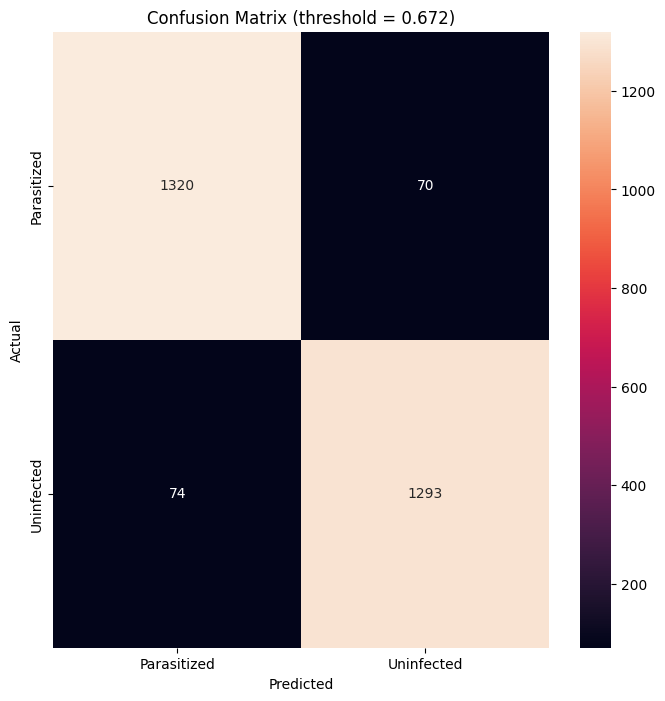

In [ ]:
threshold=0.672

cm = confusion_matrix(labels, predicted > threshold)
print(cm)

class_names = ["Parasitized","Uninfected"]

plt.figure(figsize=(8, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="rocket",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [ ]:
wandb.log({
    "ROC Curve": wandb.Image(fig)
})
plt.close(fig)


In [ ]:
def create_confusion_matrix_figure(all_y, preds, threshold):
    cm = confusion_matrix(labels, predicted > threshold)
    print(f"Threshold {threshold}:\n{cm}")

    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="Blues")
    ax.set_title(f'Confusion Matrix (threshold={threshold})')
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    return fig

fig_05 = create_confusion_matrix_figure(labels, predicted, 0.5)
fig_08 = create_confusion_matrix_figure(labels, predicted, 0.672)

wandb.log({
    "Confusion Matrices": [
        wandb.Image(fig_05, caption="Threshold 0.5"),
        wandb.Image(fig_08, caption="Threshold 0.672")
    ]
})

plt.close(fig_05)
plt.close(fig_08)


Threshold 0.5:
[[1301   89]
 [  54 1313]]
Threshold 0.672:
[[1320   70]
 [  74 1293]]


In [ ]:
wandb.finish()

epoch/accuracy,▁▇▇▇████████████████
epoch/auc,▁▇▇▇████████████████
epoch/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch/fn,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/fp,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/learning_rate,████▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/precision,▁▇▇▇▇█▇█████████████
epoch/recall,▁▇▇█████████████████
epoch/tn,▁▇▇▇▇█▇█████████████
+11,...


# Conclusion

Since this is a medical classification task, misclassifying parasitized patients as uninfected is more severe than the opposite error.

At the default threshold (0.5), the model produces 89 parasitized samples classified as uninfected.
Using ROC-based threshold selection (0.672), this number is reduced to 70, at the cost of increasing uninfected samples classified as parasitized from 54 to 75.

Given the application context, the ROC-optimized threshold is preferred, as it reduces missed infections while introducing a manageable increase in false alarms.